In [1]:
pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19532 sha256=b7c8d12ebaead929128ea1b105898372240b30509b5bb06a4fa171a65e3b7883
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


**This one is for NCC LOSS**

In [2]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [3]:
!nvidia-smi

Sat Dec 16 03:56:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne

In [5]:
dir_folder = os.path.join('/content/drive','My Drive','hw4','Dataset_HW4')

In [6]:
train_folder = os.path.join(dir_folder,'train')
test_folder = os.path.join(dir_folder,'test')

In [7]:
def load_img(files_path):

    batch_size = len(files_path)
    temp_file = nib.load(files_path[0])
    img_shape = temp_file.shape
    img_array = np.zeros([batch_size,*img_shape])

    for i,files in enumerate(files_path):

        img = nib.load(files)
        img_array[i] = img.get_fdata()

    return np.expand_dims(img_array,axis = -1)

In [8]:
def data_generator(dir_folder,batch_size = 32):

    while True:

        files = os.listdir(dir_folder)
        #print(files)
        num_files = len(files)
        idx1 = np.random.randint(0,num_files,size = batch_size)
        files_1 = [os.path.join(dir_folder,files[i]) for i in idx1]
        moving_images = load_img(files_1)

        idx2 = np.random.randint(0,num_files,size = batch_size)
        files_2 = [os.path.join(dir_folder,files[i]) for i in idx2]
        fixed_images = load_img(files_2)

        inputs = [moving_images,fixed_images]

        img_shape = moving_images.shape[1:]
        img_shape = img_shape[:-1]

        ndims = len(img_shape)
        zero_phi = np.zeros([batch_size,*img_shape,ndims])
        outputs = [fixed_images,zero_phi]

        yield (inputs,outputs)

    # while True:

    #     idx1 = np.random.randint(0,num_files,size = batch_size)

    #     moving_images = load_img(

In [18]:
#compile model

vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
ncc_loss = vxm.tf.losses.NCC(win = 9)
losses = [ncc_loss.loss,vxm.losses.Grad('l2').loss]
loss_weights = [1,0.01]

vxm_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4), loss = losses, loss_weights=loss_weights)

In [19]:
train_generator = data_generator(train_folder,batch_size = 1)

In [20]:
# training the model
hist = vxm_model.fit(train_generator,epochs = 3, steps_per_epoch = 800, verbose = 2)

Epoch 1/3
800/800 - 515s - loss: -7.9815e-01 - vxm_dense_transformer_loss: -7.9920e-01 - vxm_dense_flow_loss: 0.1056 - 515s/epoch - 644ms/step
Epoch 2/3
800/800 - 409s - loss: -8.6557e-01 - vxm_dense_transformer_loss: -8.6713e-01 - vxm_dense_flow_loss: 0.1559 - 409s/epoch - 511ms/step
Epoch 3/3
800/800 - 409s - loss: -8.8124e-01 - vxm_dense_transformer_loss: -8.8296e-01 - vxm_dense_flow_loss: 0.1718 - 409s/epoch - 511ms/step


In [21]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

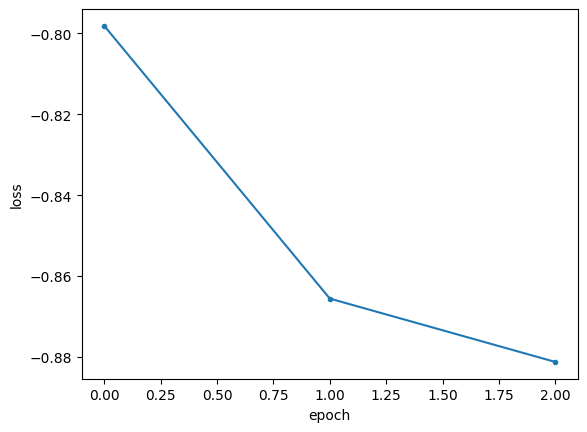

In [22]:
plot_history(hist)

In [23]:
def data_generator_test(dir_folder,img_type,batch_size = 32):

    while True:

        files = [file for file in os.listdir(dir_folder) if file[0:3] == img_type]
        #print(files)
        num_files = len(files)
        idx1 = np.random.randint(0,num_files,size = batch_size)
        files_1 = [os.path.join(dir_folder,files[i]) for i in idx1]
        moving_images = load_img(files_1)

        idx2 = np.random.randint(0,num_files,size = batch_size)
        files_2 = [os.path.join(dir_folder,files[i]) for i in idx2]
        fixed_images = load_img(files_2)

        inputs = [moving_images,fixed_images]

        img_shape = moving_images.shape[1:]
        img_shape = img_shape[:-1]

        ndims = len(img_shape)
        zero_phi = np.zeros([batch_size,*img_shape,ndims])
        outputs = [fixed_images,zero_phi]

        yield (inputs,outputs)


1/1 [==============================] - 6s 6s/step
1st moving image
2nd fixed image
3rd predicted image


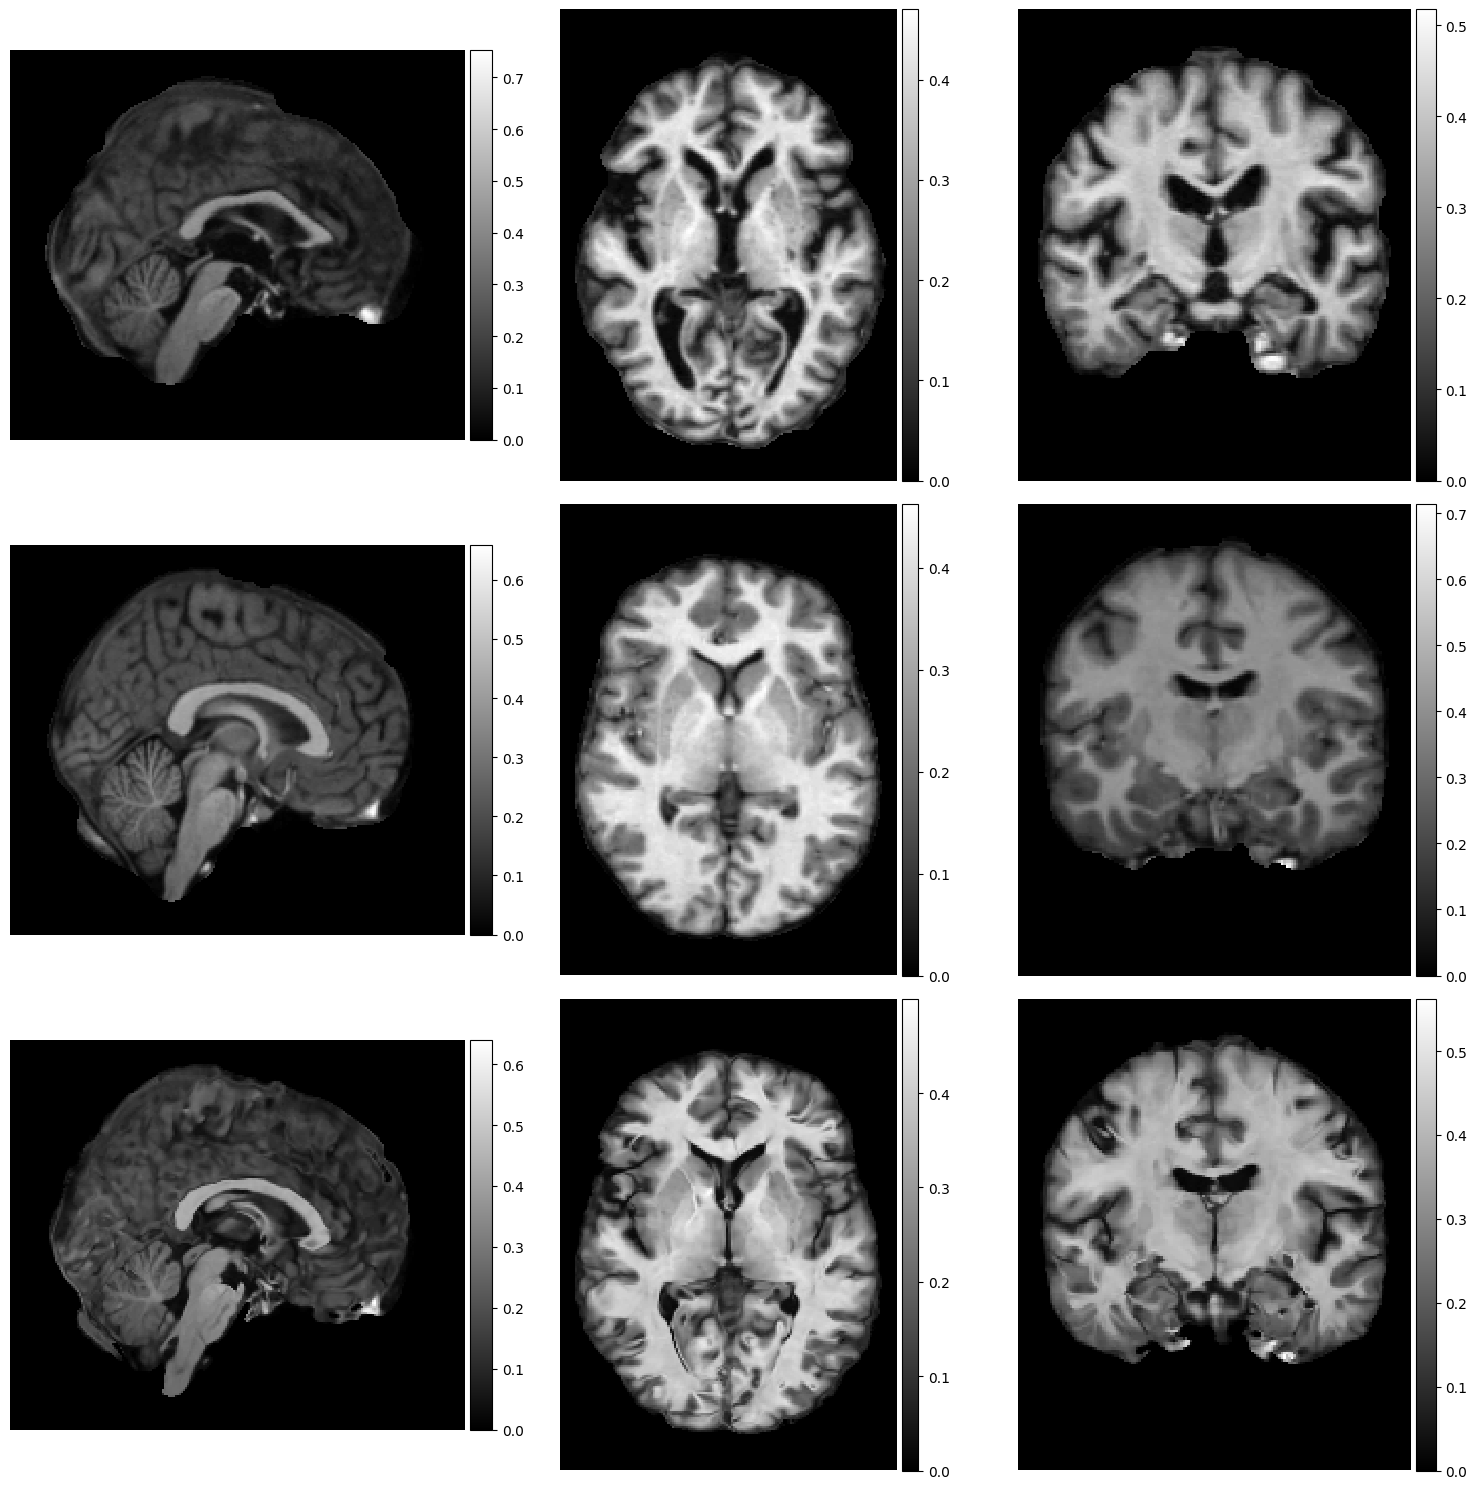

1/1 [==============================] - 0s 135ms/step
1st moving image
2nd fixed image
3rd predicted image


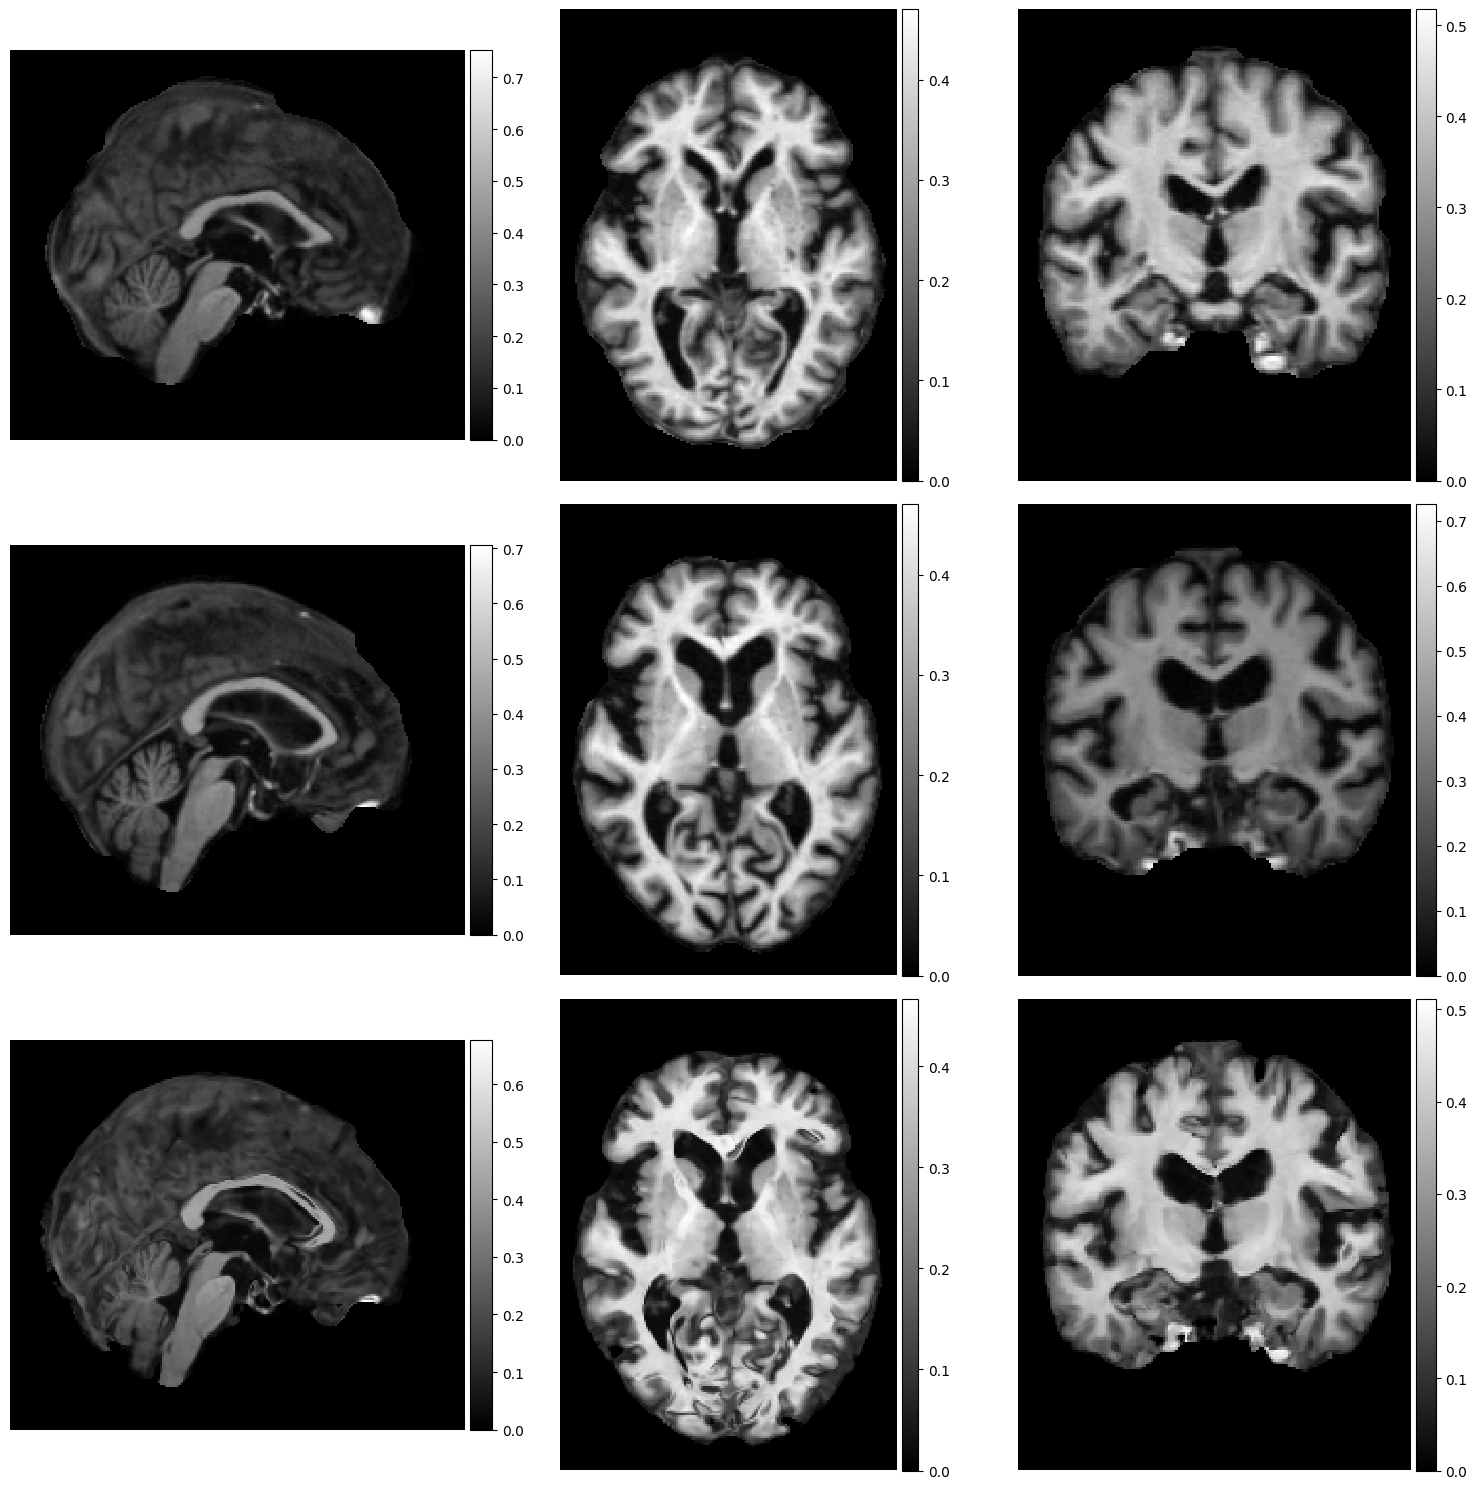

1/1 [==============================] - 0s 144ms/step
1st moving image
2nd fixed image
3rd predicted image


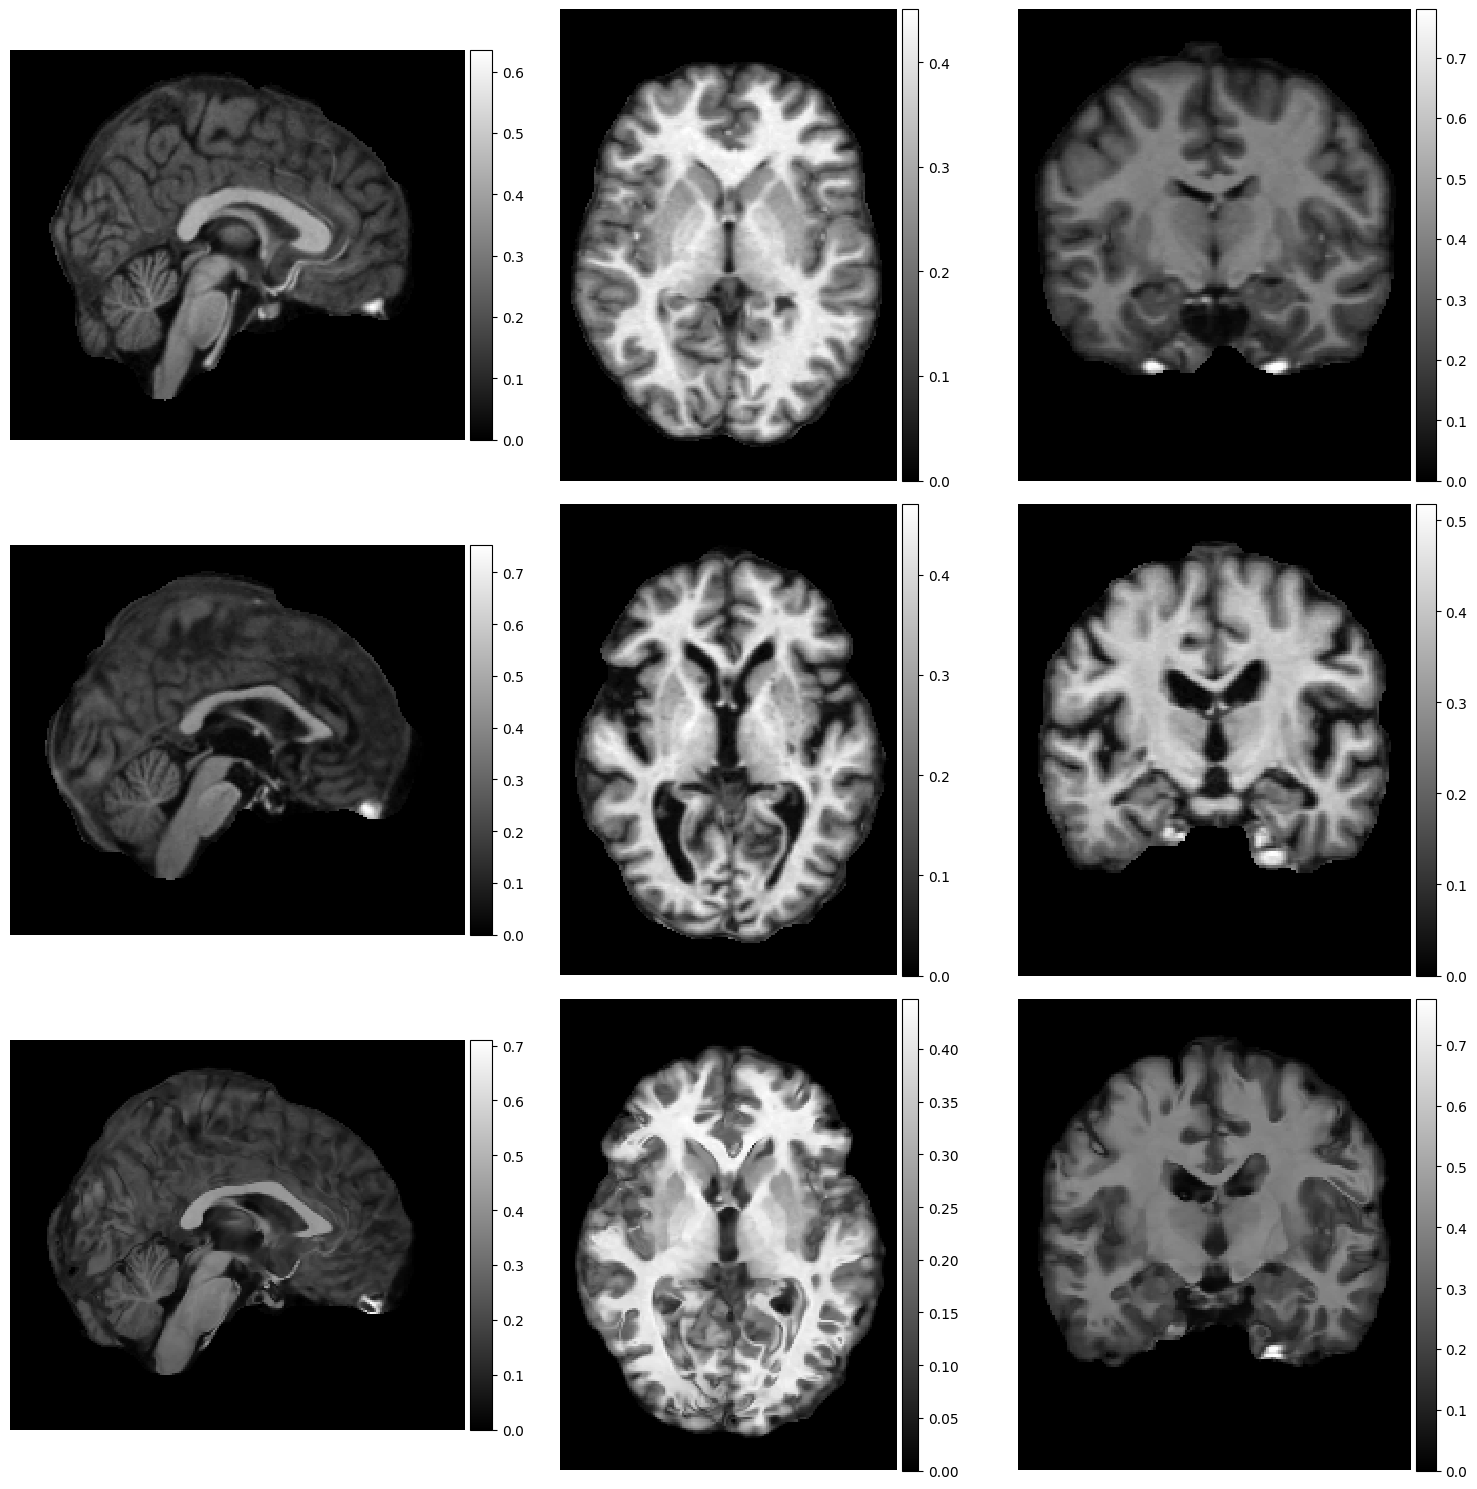

1/1 [==============================] - 0s 138ms/step
1st moving image
2nd fixed image
3rd predicted image


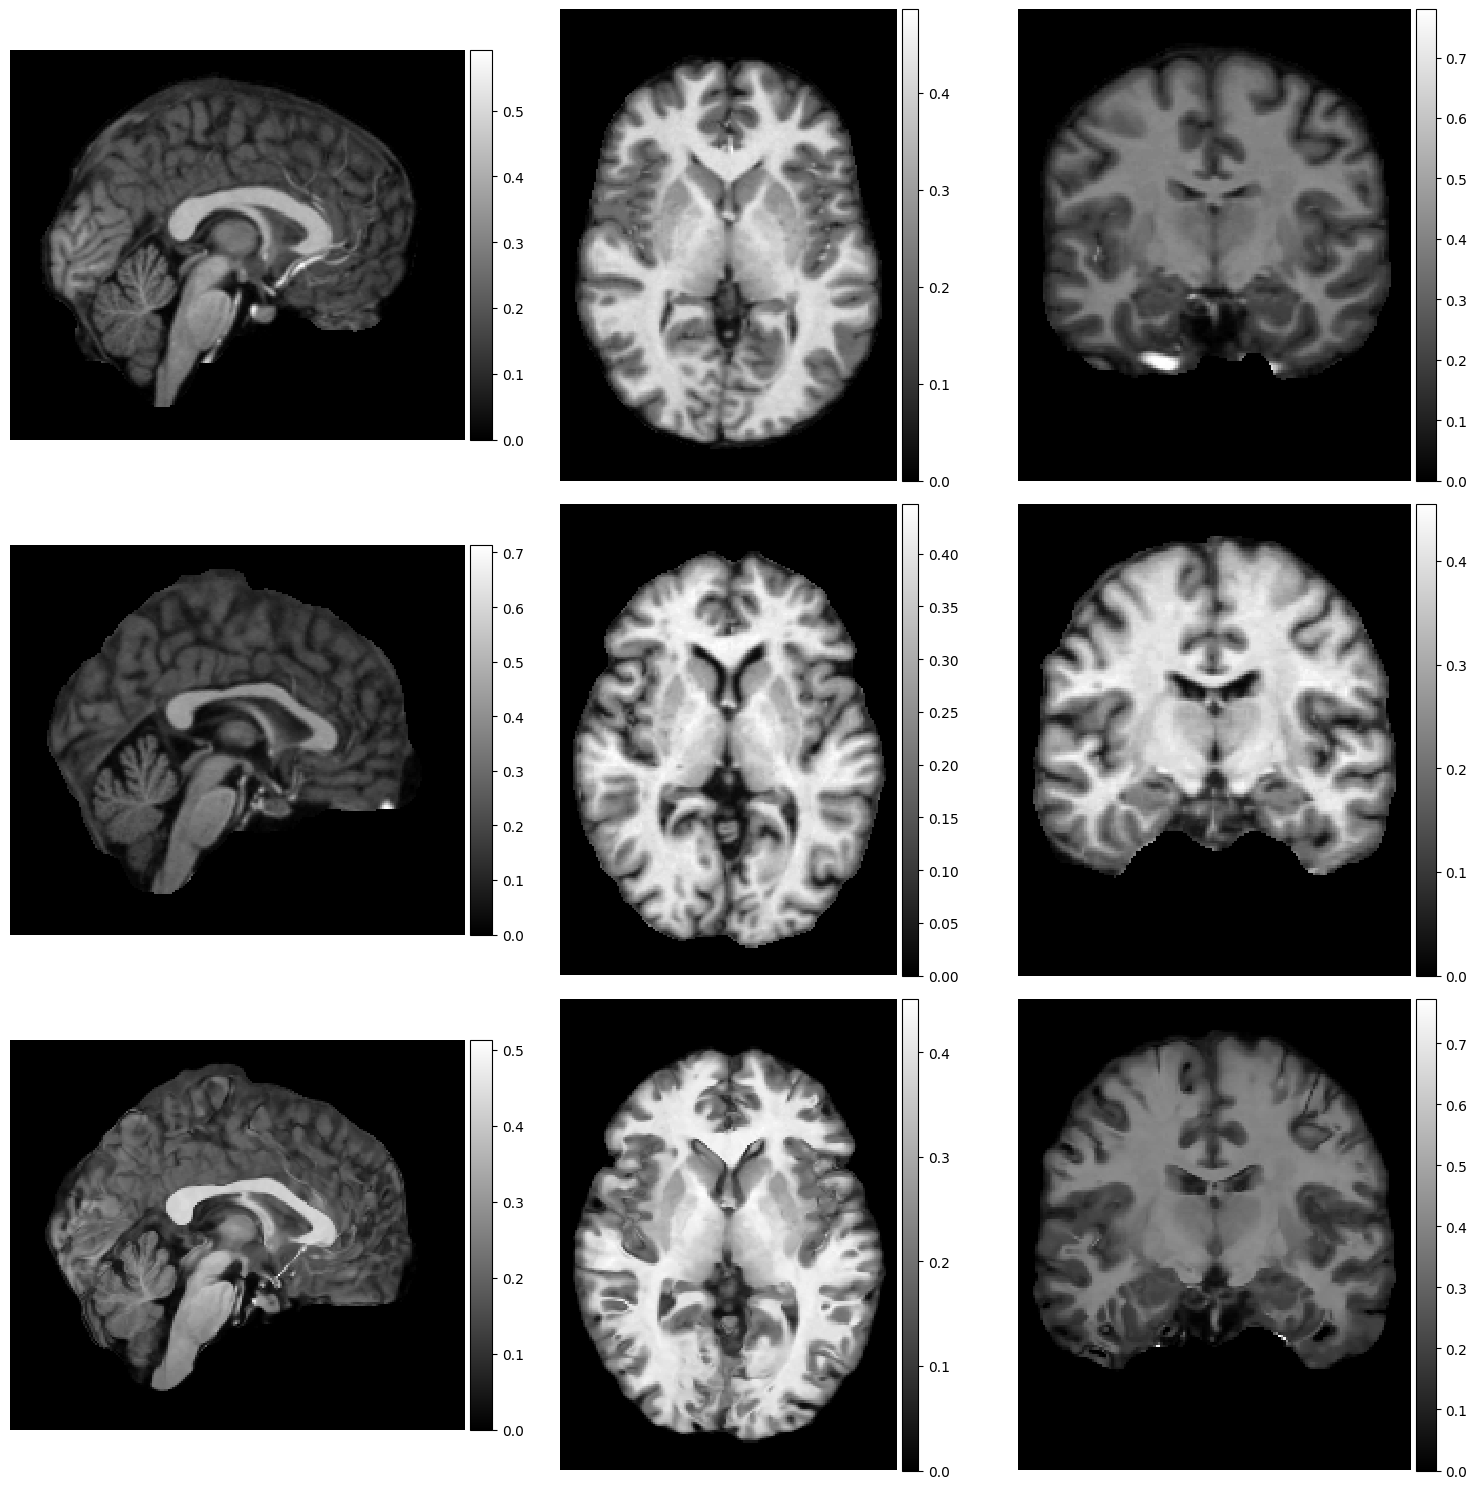

1/1 [==============================] - 0s 134ms/step
1st moving image
2nd fixed image
3rd predicted image


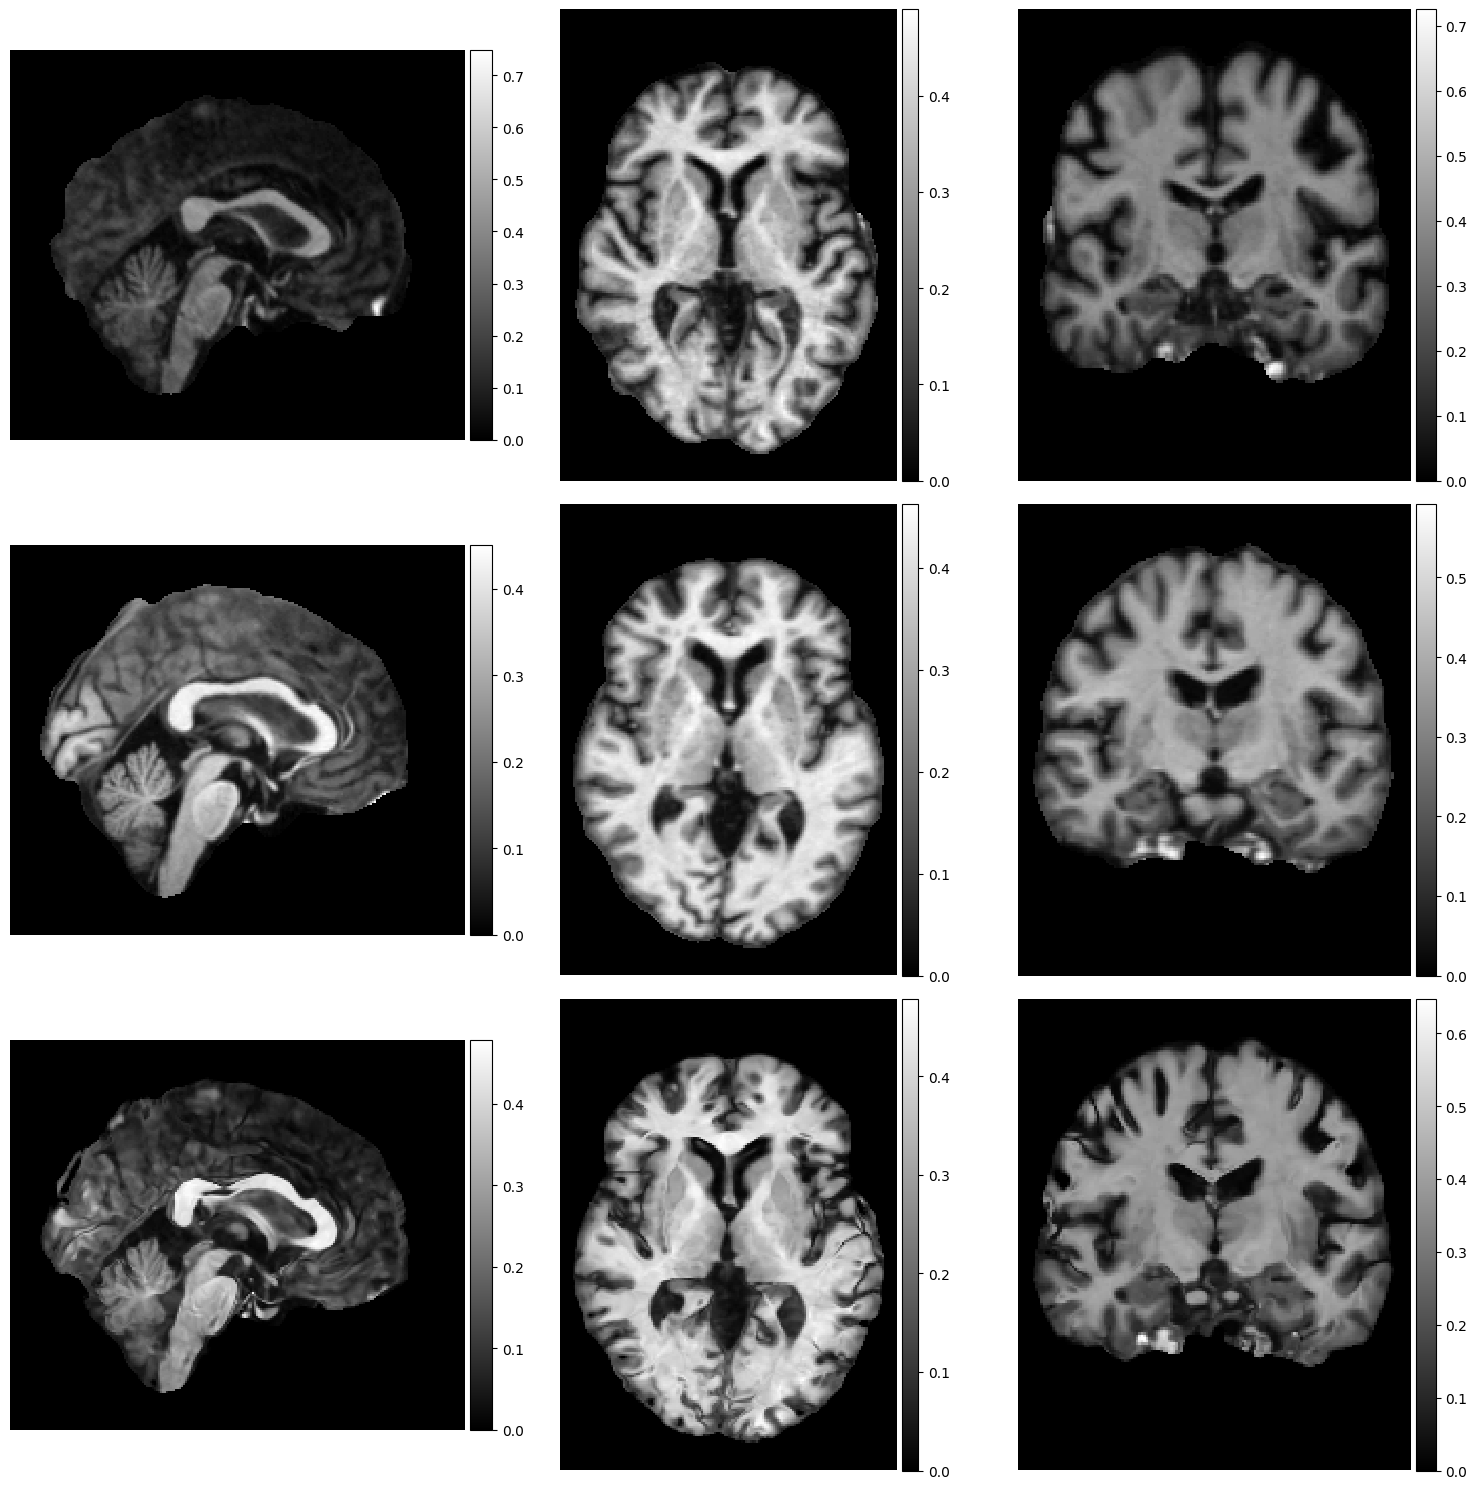

In [24]:
# showing the visulaization result for the given trained model. Task 2 for the images

num_pairs = 5
test_generator = data_generator_test(test_folder,'img',batch_size = 1)

for i in range(num_pairs):

    inputs,outputs = next(test_generator)
    val_pred = vxm_model.predict(inputs)
    val_volume_1 = inputs[0][0,:,:,:,0]
    val_volume_2 = inputs[1][0,:,:,:,0]
    moved_pred = val_pred[0][0,:,:,:,0]
    print('1st moving image')
    mid_slices_moving = [np.take(val_volume_1, vol_shape[d]//2, axis=d) for d in range(3)]
    mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
    mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)
    print('2nd fixed image')
    mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
    mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
    mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)
    print('3rd predicted image')
    mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
    mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
    mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
    ne.plot.slices(mid_slices_moving + mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3])


In [25]:
vxm_model.save_weights('model_ncc_hw4_weights.h5')

In [26]:
#restarting witht he notebook. Loading the weights of the NN.
weight_path = os.path.join(dir_folder,'model_ncc_hw4_weights.h5')
vxm_model.load_weights(weight_path)

In [27]:
# to get both img and segments , data generator
def data_generator_test_seg(dir_folder,img_type,batch_size = 1):

    files = [file for file in os.listdir(dir_folder) if file[0:3] == img_type]
    segs = ['seg'+file[3:] for file in files]

    while True:

        #return files,segs

        #print(files)
        num_files = len(files)
        idx1 = np.random.randint(0,num_files,size = batch_size)
        files_1 = [os.path.join(dir_folder,files[i]) for i in idx1]
        segs_1 = [os.path.join(dir_folder,segs[i]) for i in idx1]

        #print(len(files_1))
        #print(len(segs_1))

        moving_images = load_img(files_1)
        moving_images_seg = load_img(segs_1)

        idx2 = np.random.randint(0,num_files,size = batch_size)
        files_2 = [os.path.join(dir_folder,files[i]) for i in idx2]
        segs_2 = [os.path.join(dir_folder,segs[i]) for i in idx2]

        fixed_images = load_img(files_2)
        fixed_images_seg = load_img(segs_2)
        # print(len(files_1))
        # print(len(segs_1))

        inputs = [moving_images,fixed_images]

        img_shape = moving_images.shape[1:]
        img_shape = img_shape[:-1]

        ndims = len(img_shape)
        zero_phi = np.zeros([batch_size,*img_shape,ndims])
        outputs = [fixed_images,zero_phi]

        both_segs = [moving_images_seg,fixed_images_seg]

        return inputs,outputs,both_segs


In [28]:
from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

1/1 [==============================] - 0s 336ms/step
warped segmentation
1st moving image
2nd fixed image
3rd predicted image


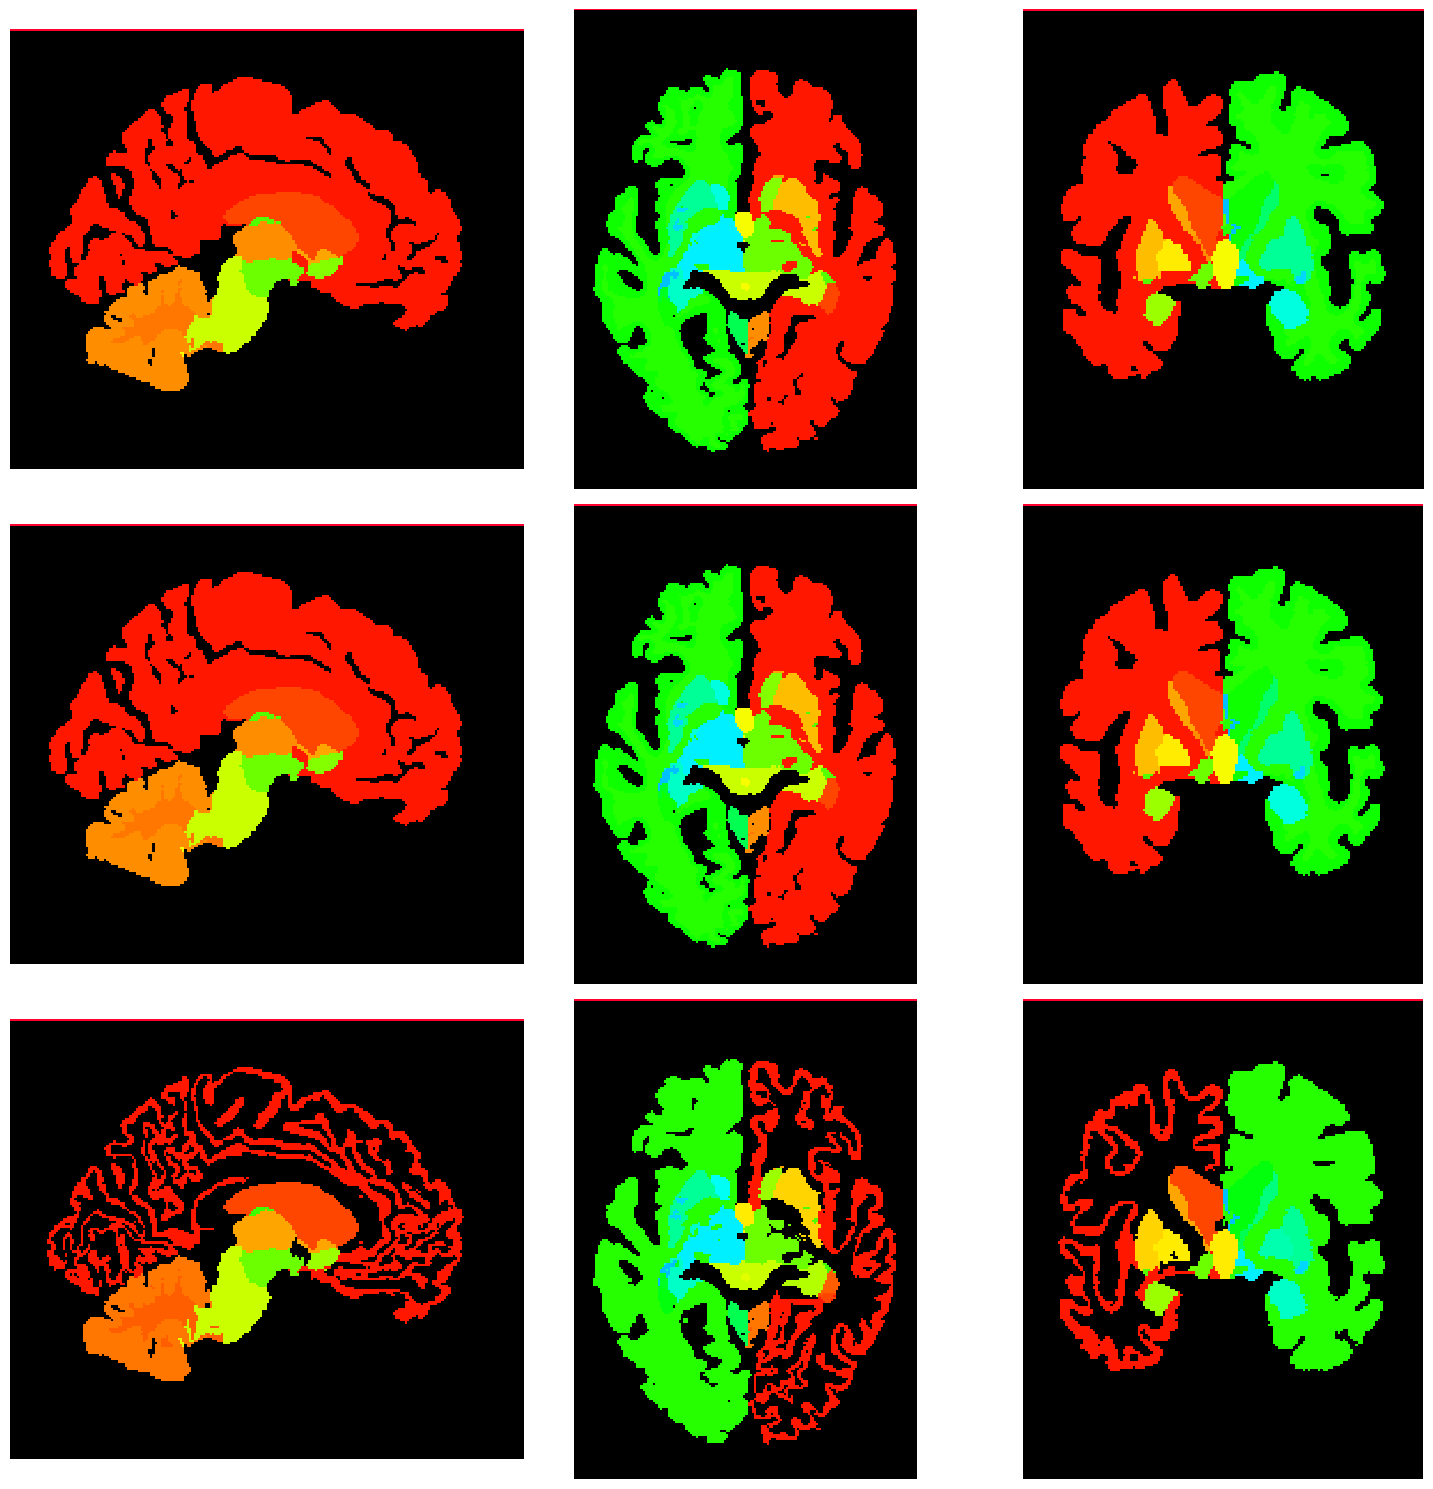

1/1 [==============================] - 0s 230ms/step
warped segmentation
1st moving image
2nd fixed image
3rd predicted image


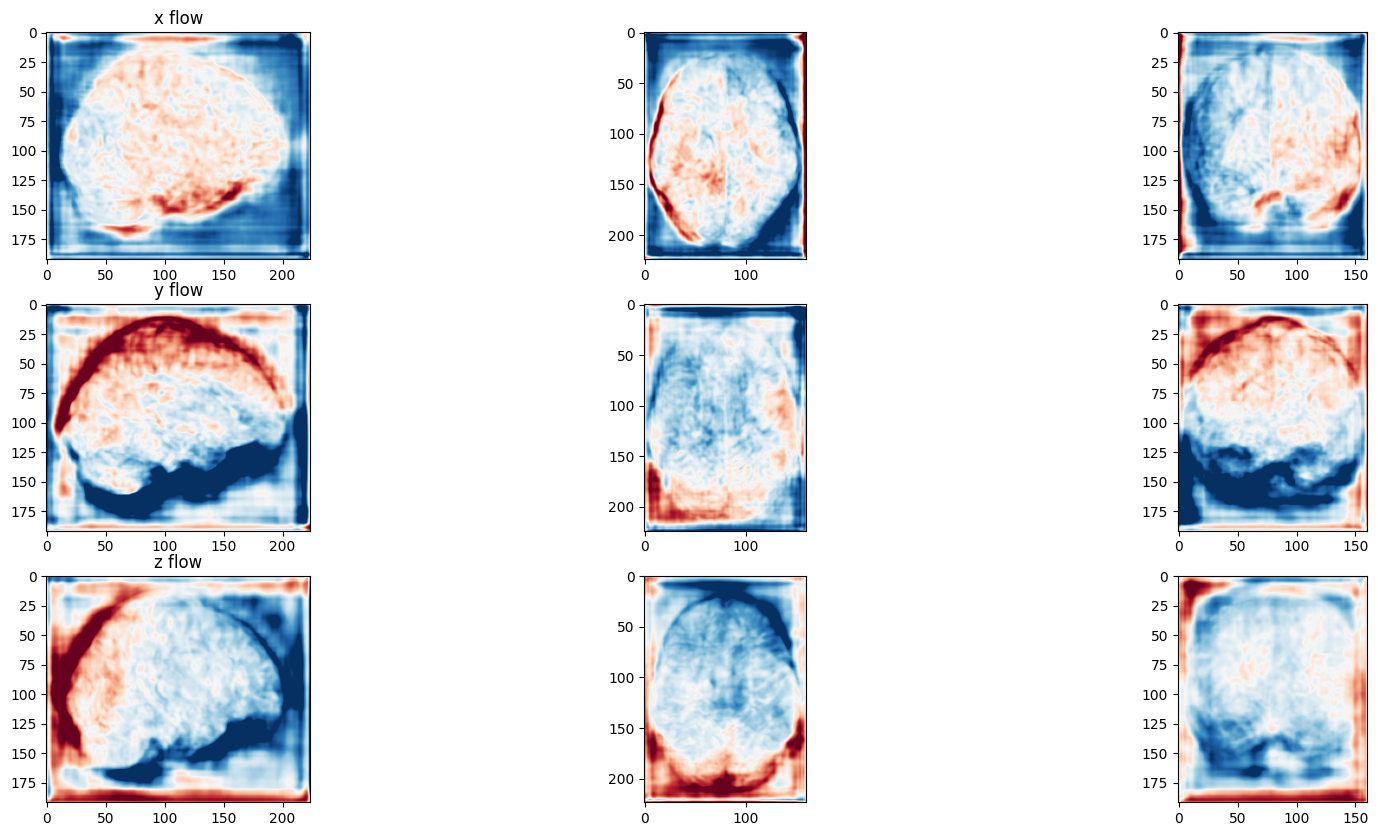

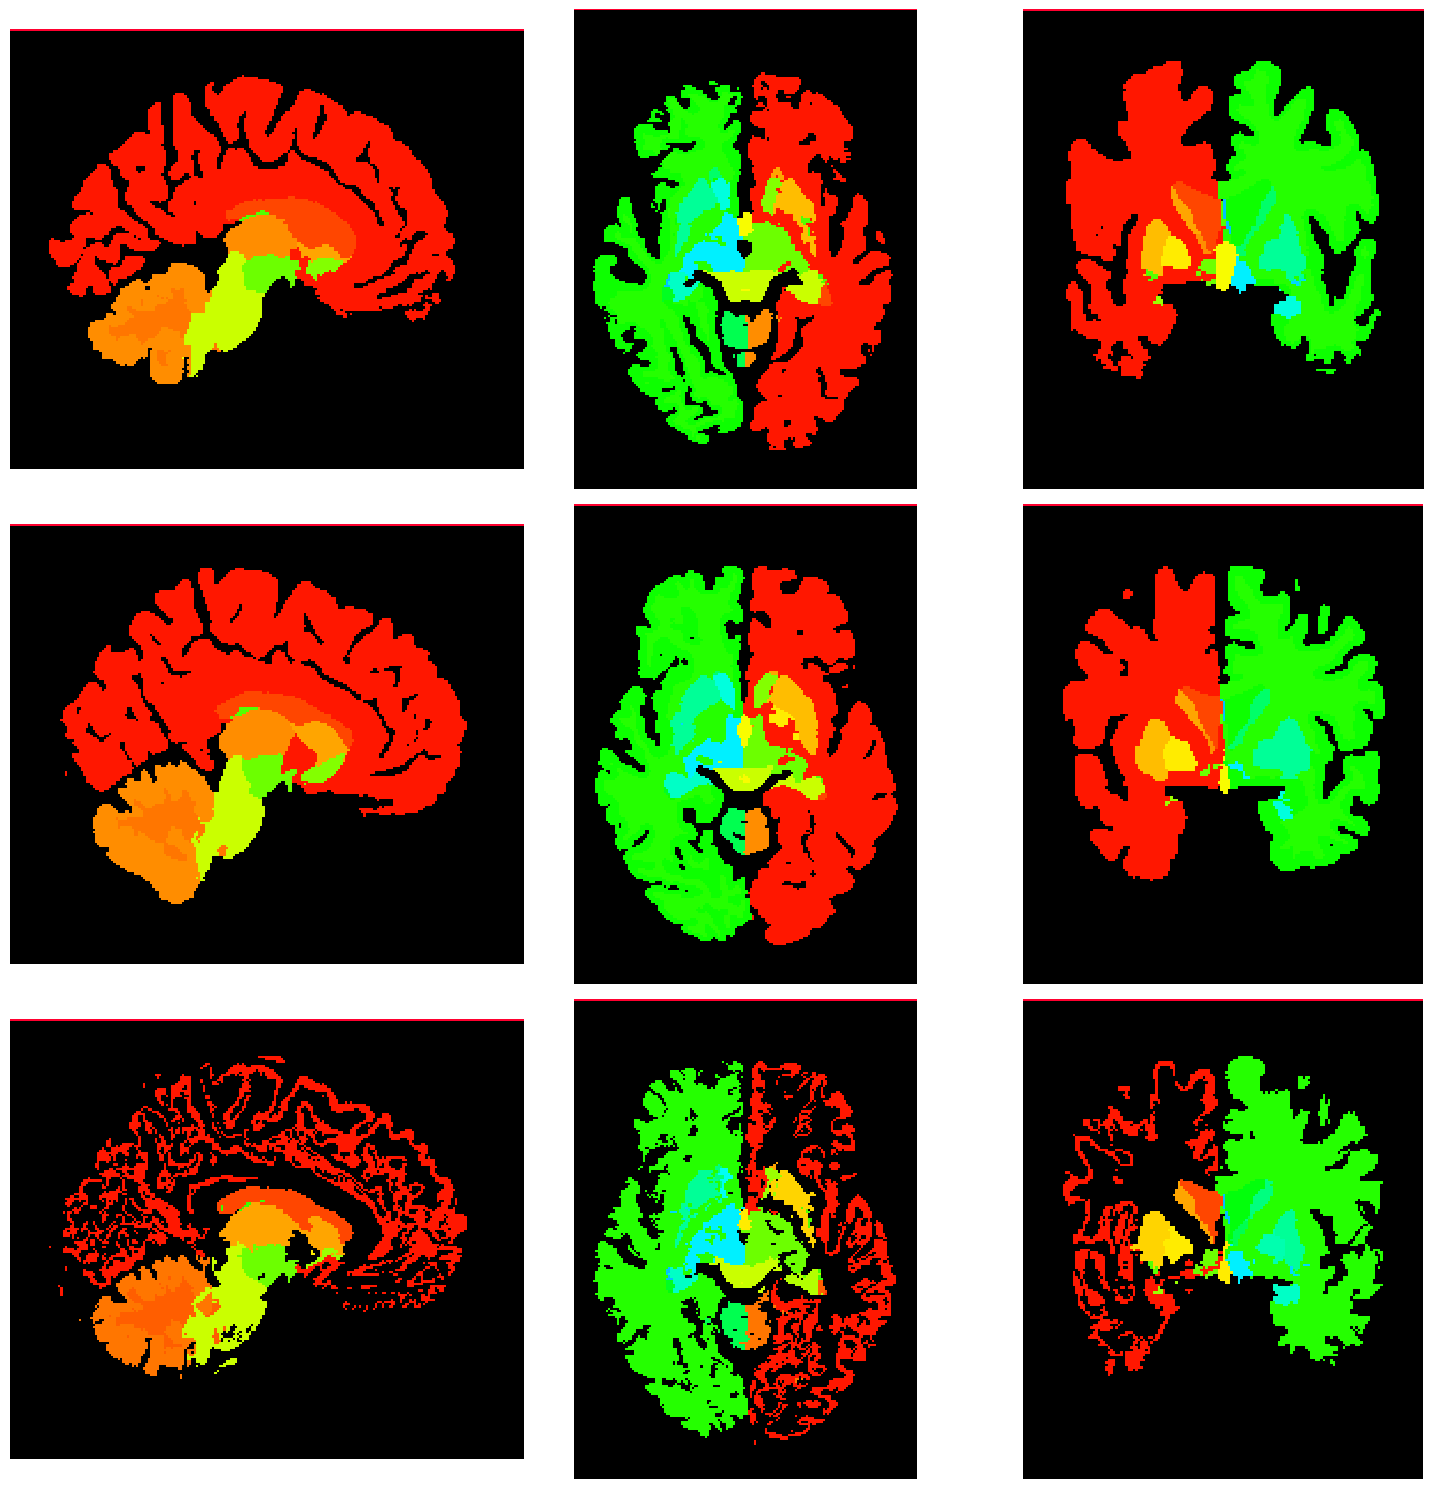

1/1 [==============================] - 0s 275ms/step
warped segmentation
1st moving image
2nd fixed image
3rd predicted image


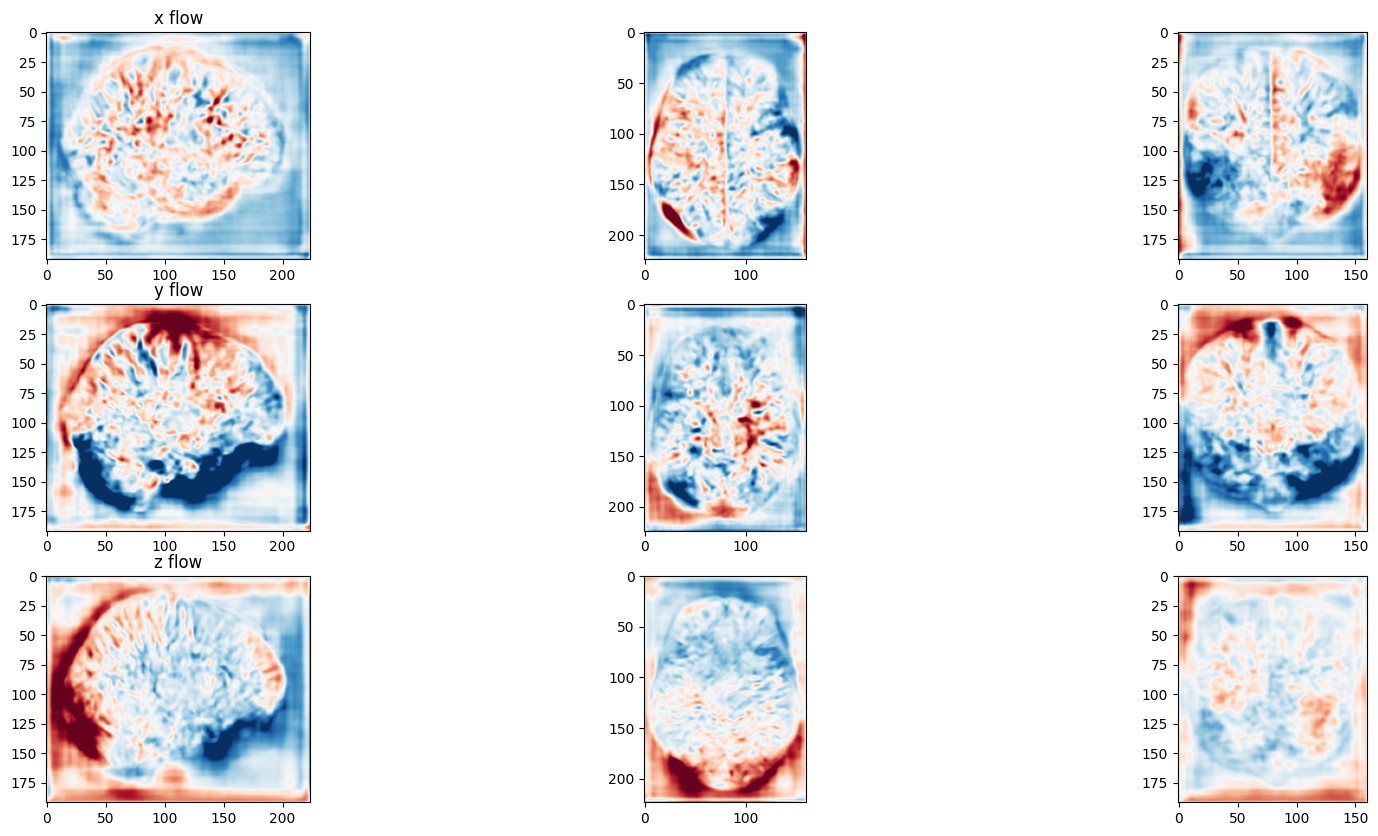

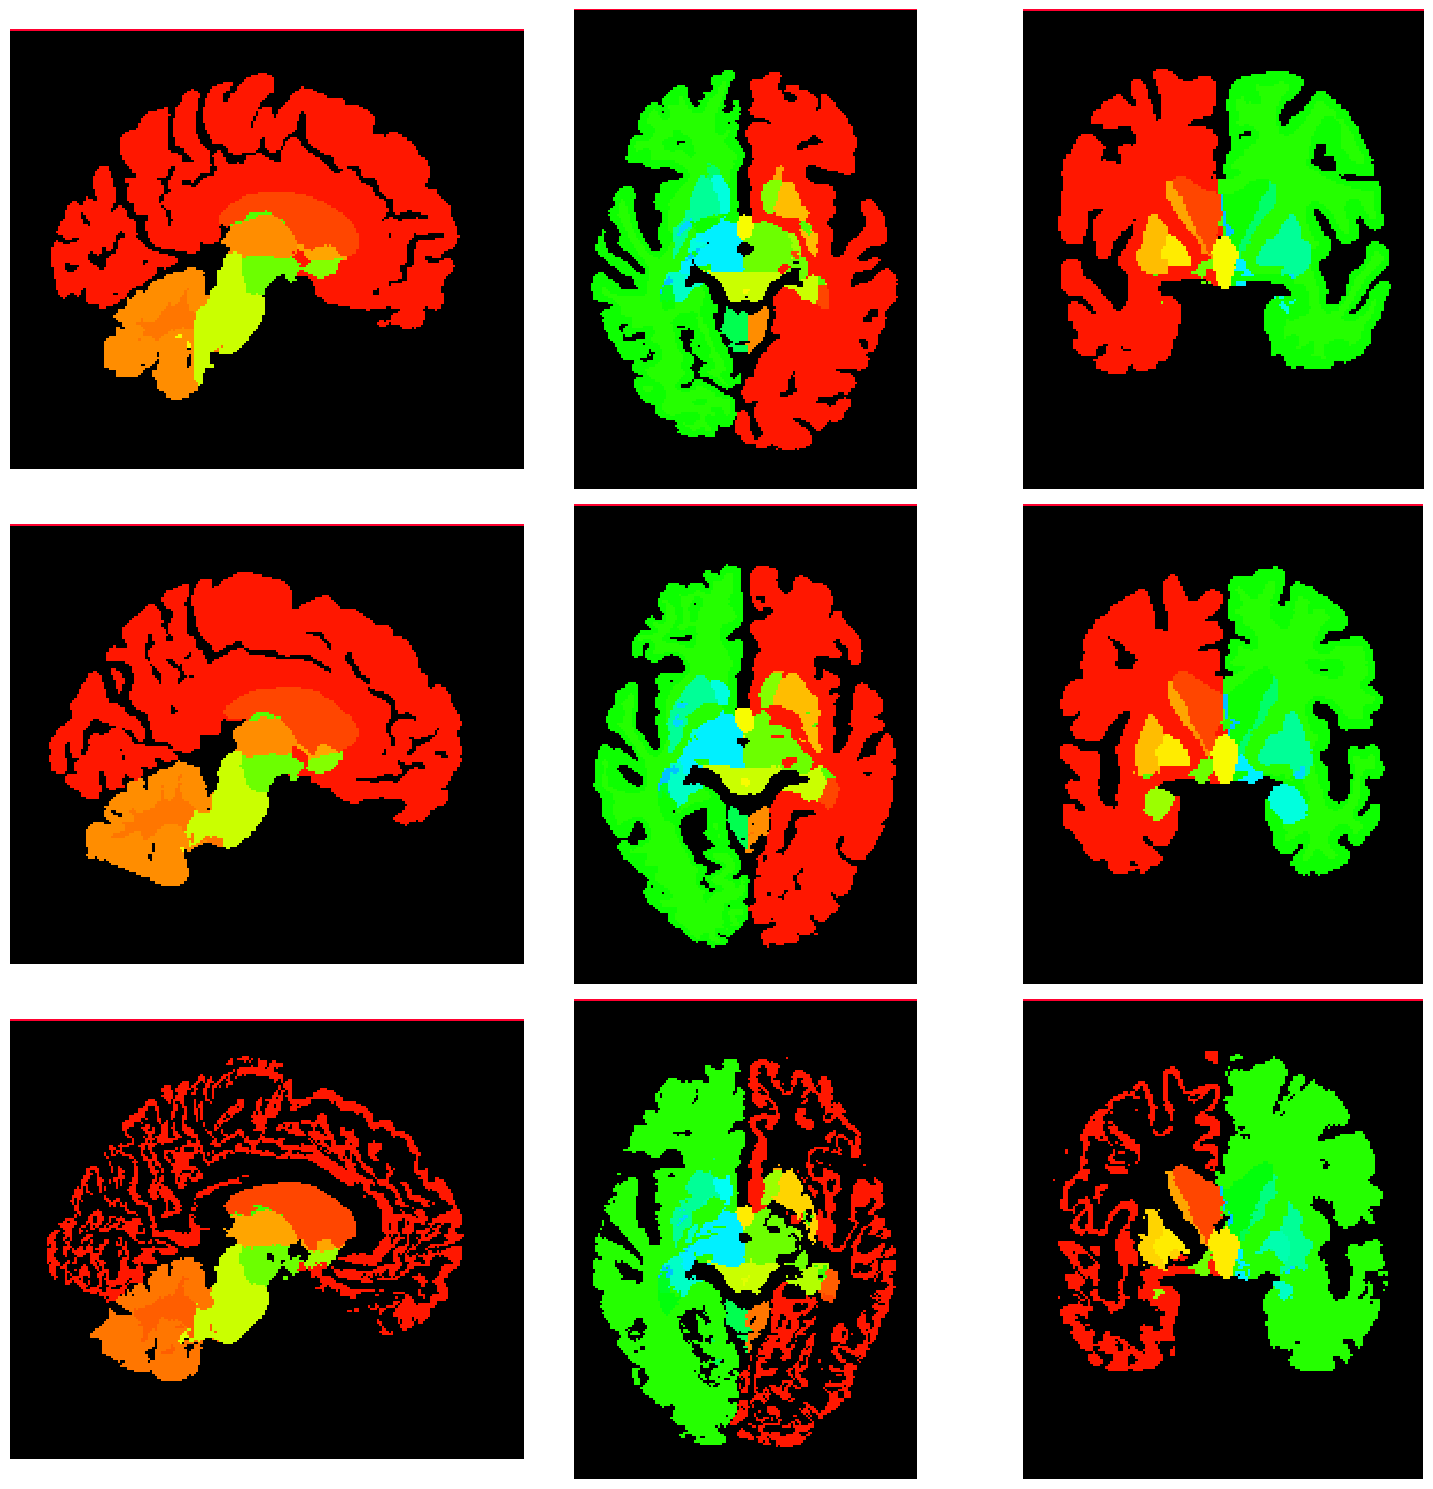

1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 237ms/step
warped segmentation
1st moving image
2nd fixed image
3rd predicted image


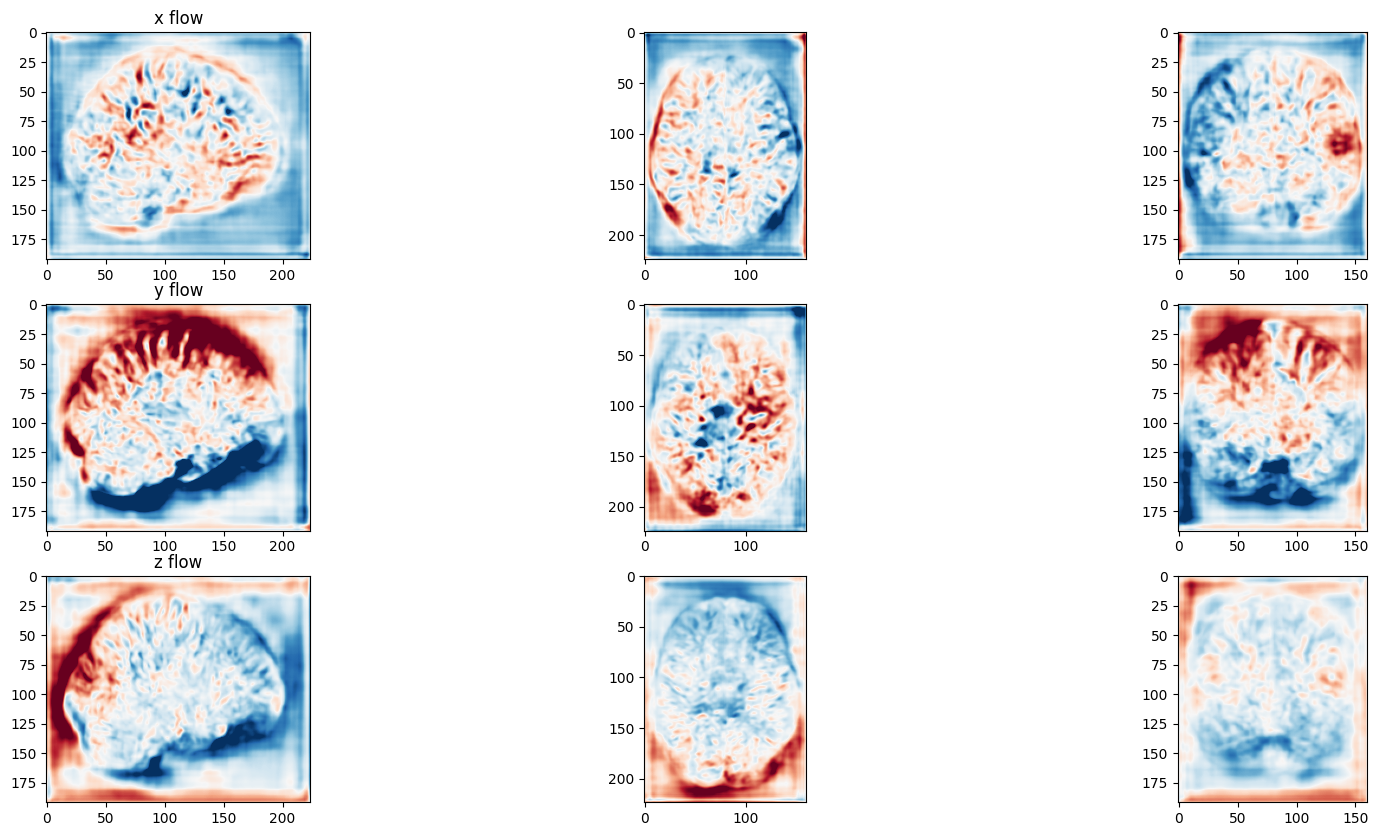

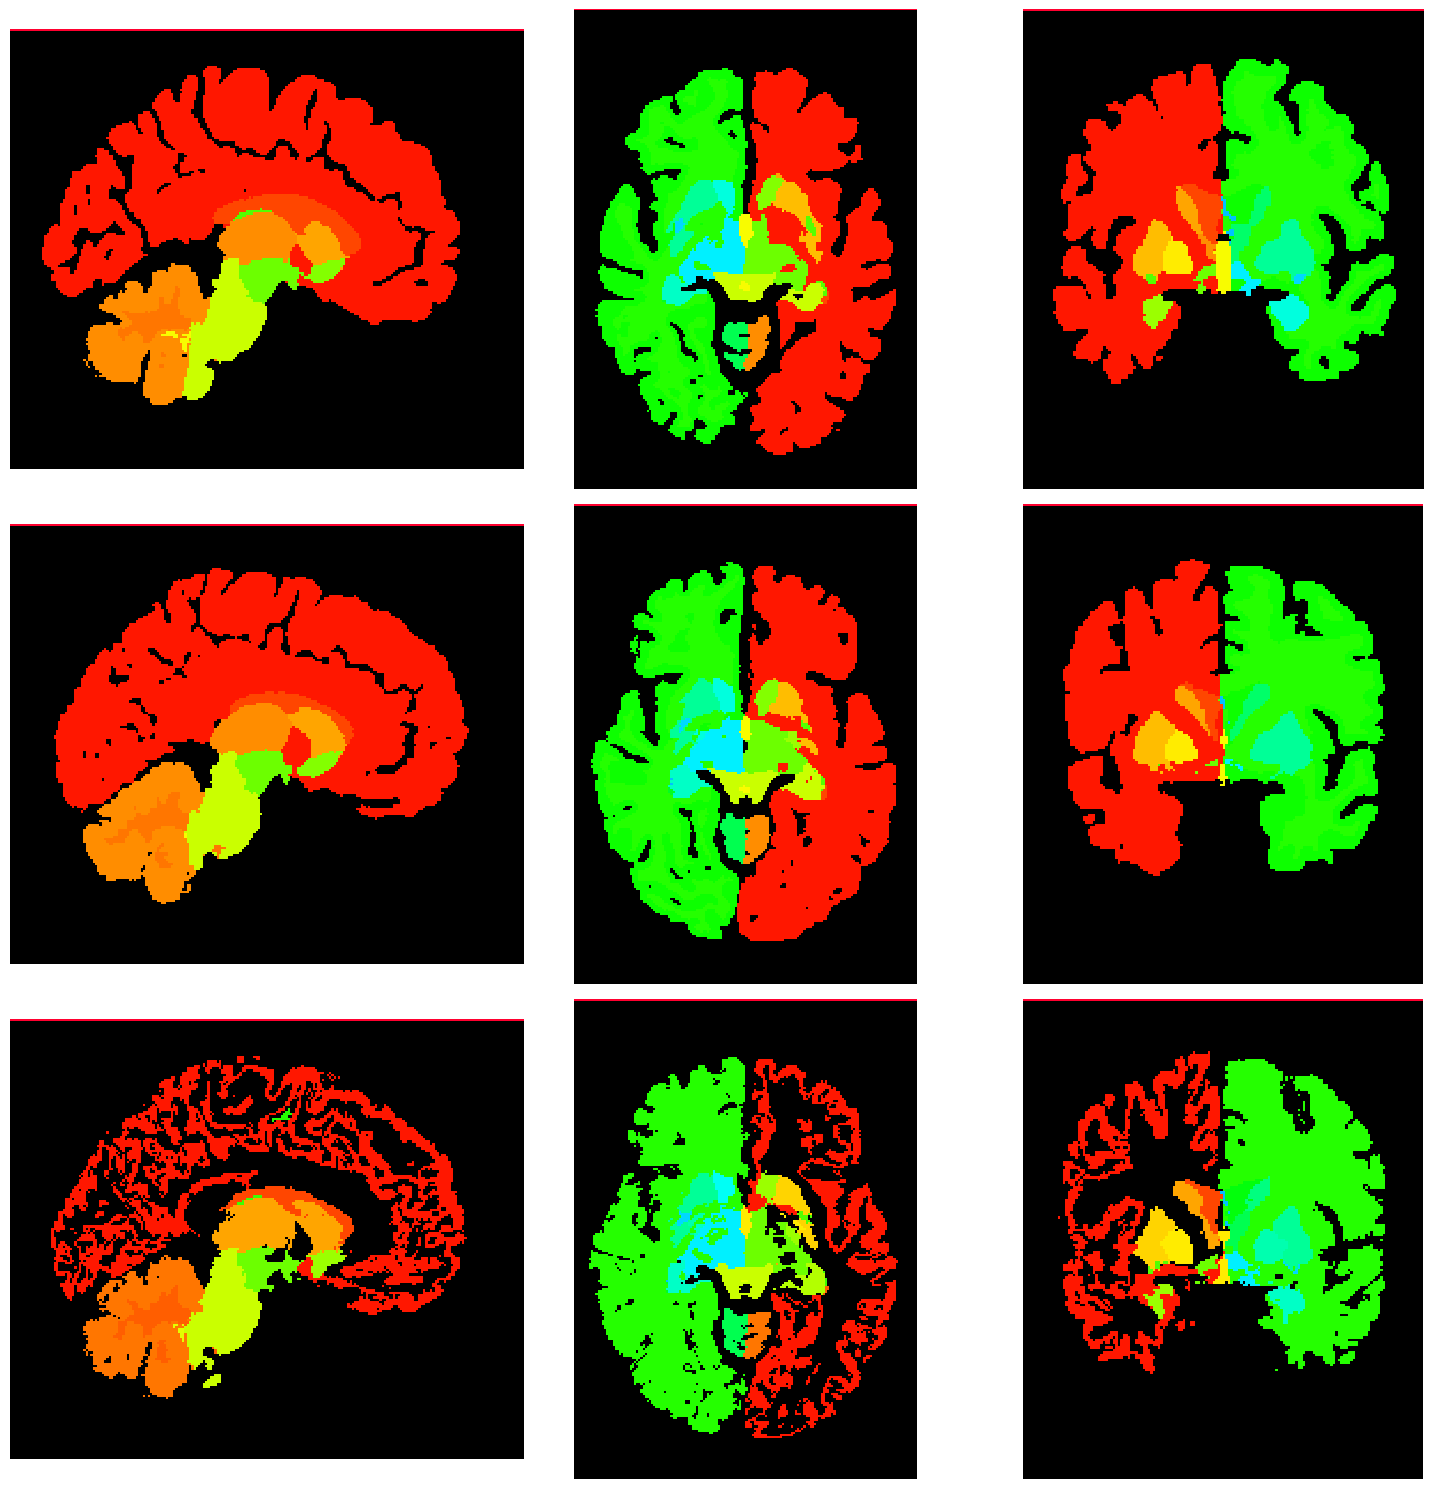

1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 245ms/step
warped segmentation
1st moving image
2nd fixed image
3rd predicted image


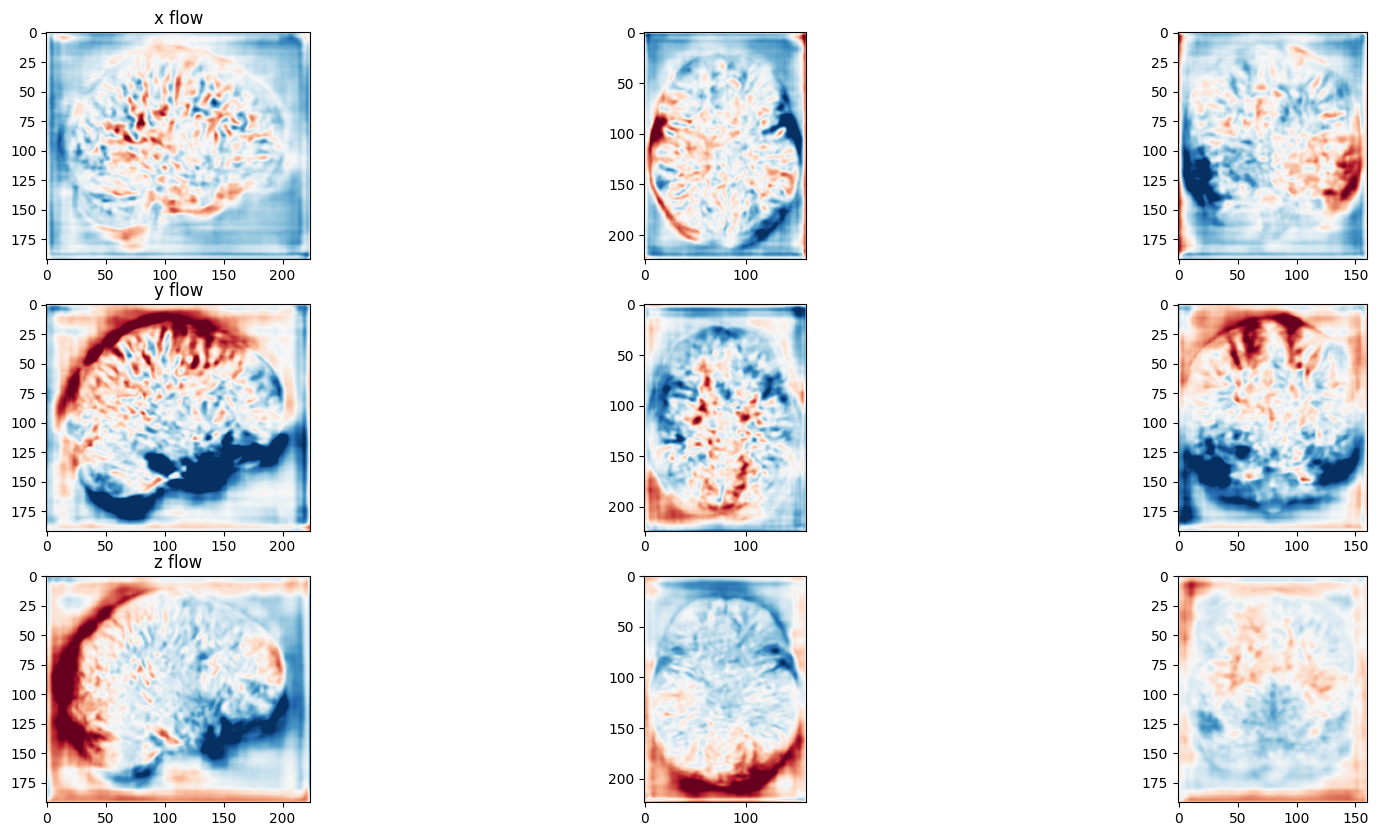

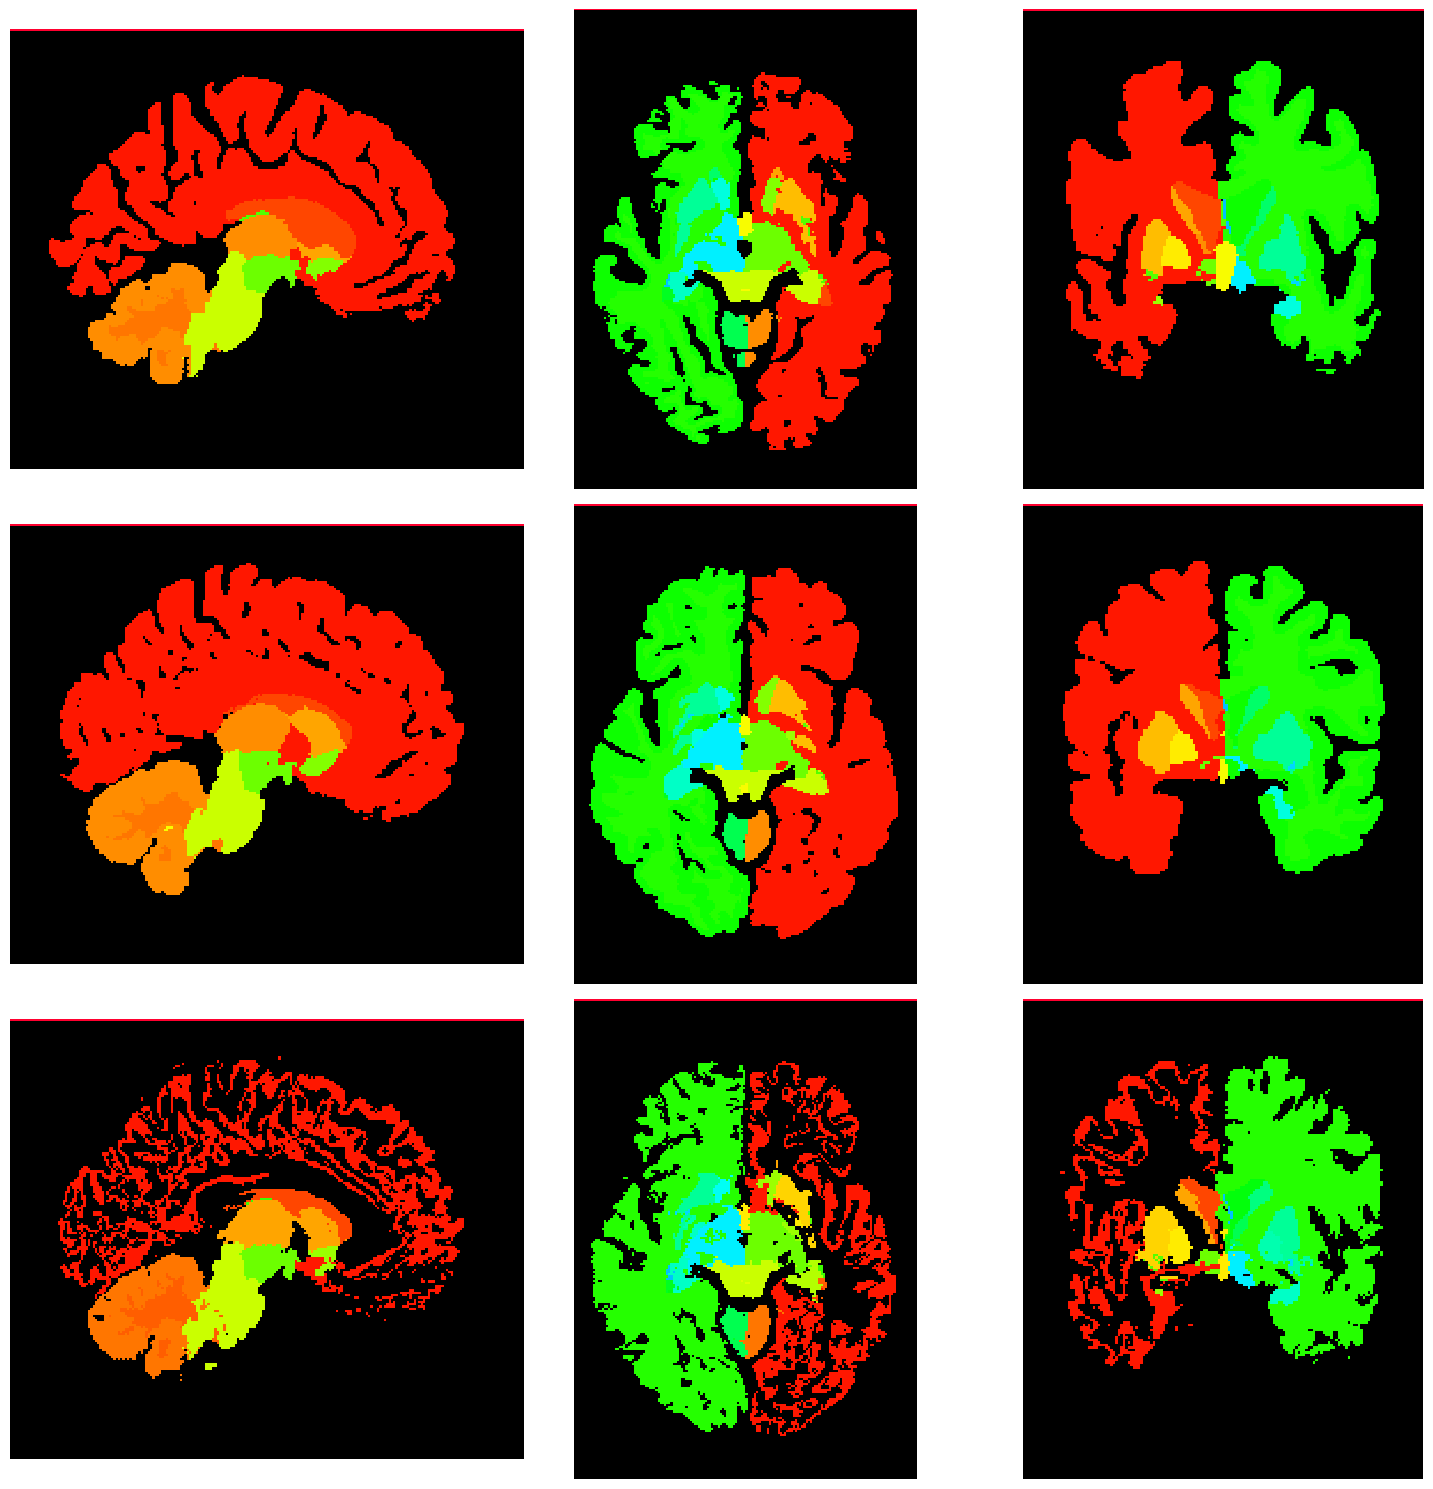

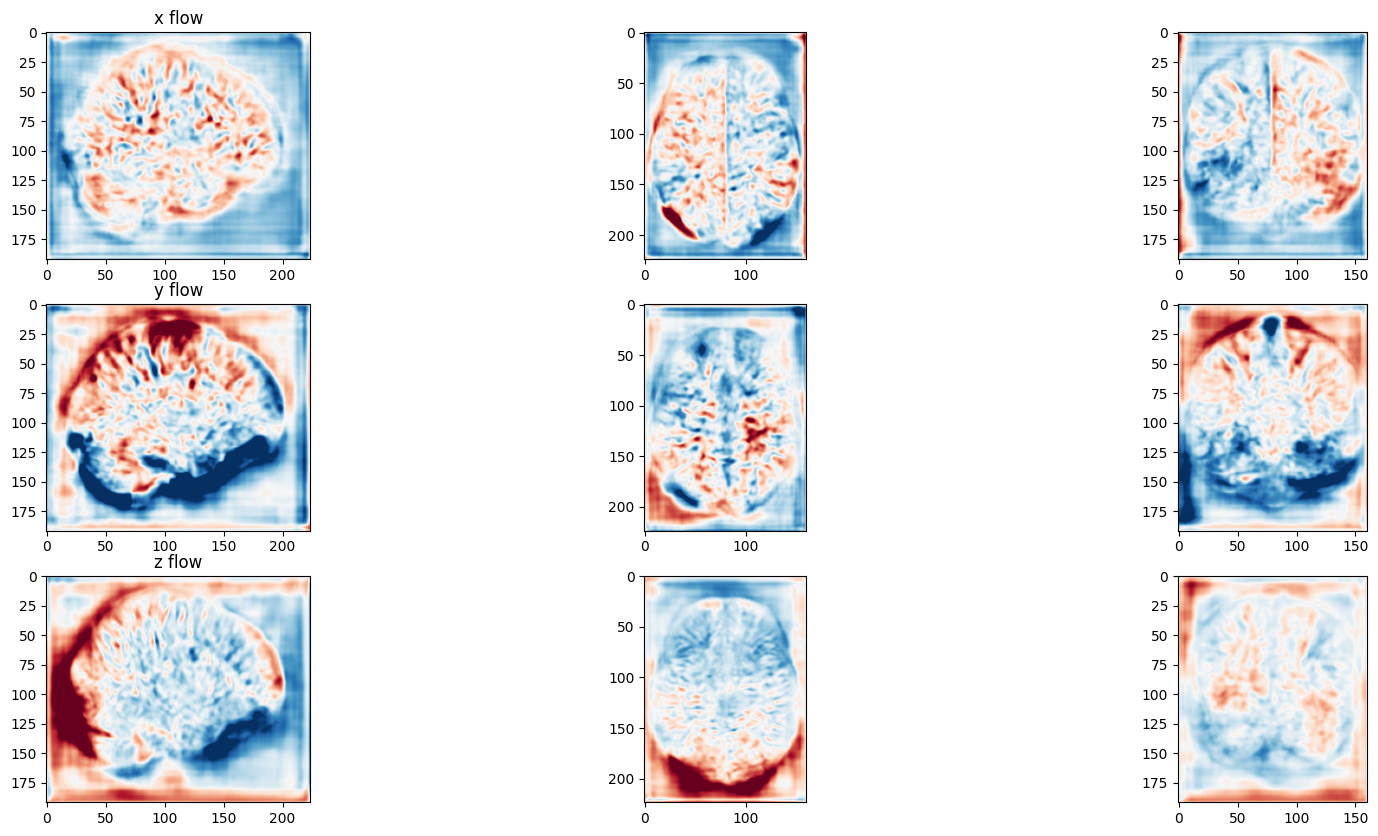

In [29]:
# showing the visulaization result for the given trained model. Task 2 for the segmentation

num_pairs = 5
test_generator = data_generator_test_seg(test_folder,'img',batch_size = 1)

for i in range(num_pairs):

    inputs,outputs,segs = data_generator_test_seg(test_folder,'img',batch_size = 1)
    val_pred = vxm_model.predict(inputs)
    moved_pred = val_pred[0][0,:,:,:,0]
    pred_warp  = val_pred[1]


    warp_model = vxm.networks.Transform(vol_shape,interp_method = 'nearest')
    warped_seg = warp_model.predict([segs[0],pred_warp])
    print('warped segmentation')

    print('1st moving image')
    mid_slices_moving = [np.take(segs[0].squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
    mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
    mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)
    print('2nd fixed image')
    mid_slices_fixed = [np.take(segs[1].squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
    mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
    mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)
    print('3rd predicted image')
    mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
    mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
    mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
    slices = mid_slices_moving + mid_slices_fixed + mid_slices_pred
    for si, slc  in enumerate(slices):
      slices[si][0] = 255
    ne.plot.slices(slices, cmaps = [ccmap], grid=[3,3]);

    flow = val_pred[1][0, :, :, :, :]
    flow_sd = np.std(flow)
    v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)
    fig, m_axs = plt.subplots(3, 3, figsize = (20, 10))
    for i, (ax1, ax2, ax3) in enumerate(m_axs):
        ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
        ax1.set_title('xyz'[i]+' flow')
        ax2.imshow(np.rot90(np.mean(flow[:, :, :, i], 1),1), **v_args)
        ax3.imshow(np.rot90(np.mean(flow[:, :, :, i], 2),-1), **v_args)


In [30]:
def dice_coef(segmentation1, segmentation2):

    unique_labels1 = np.unique(segmentation1)
    unique_labels2 = np.unique(segmentation2)

    # Exclude background label (usually 0) from calculations
    unique_labels1 = unique_labels1[unique_labels1 != 0]
    unique_labels2 = unique_labels2[unique_labels2 != 0]

    dice_scores = []

    for label1 in unique_labels1:
            # Create binary masks for each pair of labels
          mask1 = (segmentation1 == label1).astype(int)
          mask2 = (segmentation2 == label1).astype(int)

            # Calculate Dice coefficient for the pair
          intersection = np.sum(mask1 * mask2)
          total_voxels = np.sum(mask1) + np.sum(mask2)
          dice_coefficient = 2.0 * intersection / total_voxels if total_voxels > 0 else 0.0

          dice_scores.append(dice_coefficient)

    # Calculate average Dice score
    average_dice_score = np.mean(dice_scores) if len(dice_scores) > 0 else 0.0

    return average_dice_score

In [31]:
num_pairs = 10
dice_score = []
hausdroff_distance = []
for i in range(num_pairs):

    inputs,outputs,segs = data_generator_test_seg(test_folder,'img',batch_size = 1)
    val_pred = vxm_model.predict(inputs)
    moved_pred = val_pred[0][0,:,:,:,0]
    pred_warp  = val_pred[1]


    warp_model = vxm.networks.Transform(vol_shape,interp_method = 'nearest')
    warped_seg = warp_model.predict([segs[0],pred_warp])

    dice_score.append(dice_coef(segs[1].squeeze(),warped_seg.squeeze()))
    print(dice_score[i])
    #hausdroff_distance.append(hausdorff_distance_fast(segs[1].squeeze(),warped_seg.squeeze()))
    #print(hausdroff_distance[i])

dice_score = np.array(dice_score)
mean_dice_score = np.mean(dice_score)
#hausdroff_distance = np.array(hausdroff_distance)
#mean_hausdroff_distance = np.mean(hausdroff_distance)

print(f'The mean dice score is {mean_dice_score}')
#print(f'The mean hausdroff distance is {mean_hausdroff_distance}')

1/1 [==============================] - 0s 231ms/step
0.65775952029042
1/1 [==============================] - 0s 230ms/step
0.7286383673509078
1/1 [==============================] - 0s 257ms/step
0.6214670864289982
1/1 [==============================] - 0s 259ms/step
0.7732751153526977
1/1 [==============================] - 0s 228ms/step
0.667312628331267
1/1 [==============================] - 0s 271ms/step
0.9338102400750758
1/1 [==============================] - 0s 271ms/step
0.9338102400750758
1/1 [==============================] - 0s 226ms/step
0.722431829509364
1/1 [==============================] - 0s 244ms/step
0.7425417922281696
1/1 [==============================] - 0s 249ms/step
0.697536493904502
The mean dice score is 0.7478583313546477
